In [50]:
from sklearn.decomposition import PCA
from sklearn.utils import shuffle

In [51]:
import pandas as pd

In [52]:
import numpy as np

In [340]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [54]:
import torch
from sentence_transformers import SentenceTransformer
if torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
model = SentenceTransformer('all-MiniLM-L6-v2', device=device)
print("Model is loaded on:", model.device)

/Users/bensmus/Desktop/Projects/AG_news_classify/myenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model is loaded on: mps:0


In [55]:
filename = 'AG_news_dataset/train.csv'
df = pd.read_csv(filename)
descriptions = np.array(df['Description'])
categories = np.array(df['Class Index'] - 1) # This -1 is CRUCIAL because classes must be 0...N-1 where N is number of classes.
descriptions, categories = shuffle(descriptions, categories, random_state=0)


In [56]:
embeddings = model.encode(descriptions)

In [8]:
# pca = PCA(n_components=50)
# embeddings = pca.fit_transform(embeddings)

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(embeddings, categories, test_size=0.2, random_state=42)

In [354]:
inputs = tf.keras.Input(shape=(384,))
# x = layers.Dropout(0.3)(inputs)
x = layers.Dense(200, activation='relu', kernel_regularizer=l2(0.001))(inputs) # The regularizer here has a large impact
x = layers.Dense(170, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.Dense(140, activation='relu', kernel_regularizer=l2(0.001))(x)
outputs = layers.Dense(4, activation='softmax', kernel_regularizer=l2(0.001))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_145"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_76 (InputLayer)     │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_288 (Dense)               │ (None, 200)            │        77,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_289 (Dense)               │ (None, 170)            │        34,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_290 (Dense)               │ (None, 140)            │        23,940 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_291 (Dense)               │ (None, 4)              │           564 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,674 (529.98 KB)

 Trainable params: 135,674 (529.98 KB)

 Non-trainable params: 0 (0.00 B)

In [355]:
model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [356]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8097 - loss: 1.0559 - val_accuracy: 0.8905 - val_loss: 0.5746
Epoch 2/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8885 - loss: 0.5485 - val_accuracy: 0.8922 - val_loss: 0.4735
Epoch 3/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8930 - loss: 0.4591 - val_accuracy: 0.8926 - val_loss: 0.4305
Epoch 4/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8948 - loss: 0.4211 - val_accuracy: 0.8950 - val_loss: 0.4061
Epoch 5/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8948 - loss: 0.4031 - val_accuracy: 0.8956 - val_loss: 0.3919
Epoch 6/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8966 - loss: 0.3887 - val_accuracy: 0.8979 - val_loss: 0.3844
Epoch 7/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8988 - loss: 0.3808 - val_accuracy: 0.8983 - val_loss: 0.3799
Epoch 8/50
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9000 - loss: 0.3738 - 

KeyboardInterrupt: 

In [291]:
y_val_predict_probs = model.predict(X_val)

750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 353us/step


In [292]:
y_val_predict = np.argmax(y_val_predict_probs, axis=1)

In [293]:
print('val accuracy', sum(y_val_predict == y_val) / len(y_val))

val accuracy 0.9137083333333333


In [330]:
val_accuracy = history.history['val_accuracy']
train_accuracy = history.history['accuracy']

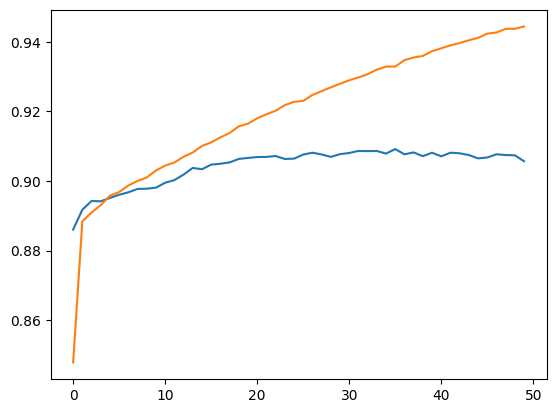

In [331]:
import  matplotlib.pyplot as plt
plt.plot(val_accuracy)
plt.plot(train_accuracy)